In [11]:
THRESHOLD = 4 * 1e-1

In [1]:
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

import numpy as np
from tqdm import trange

import matplotlib.pyplot as plt
import seaborn as sns


device = torch.device("cuda", 0)
%matplotlib inline

my_cmap = plt.cm.jet
my_cmap.set_under('white')

In [2]:
df = pd.read_csv("/home/shirobokov/data/diff_gen_data/physics_data/xz_magnet_opt.csv", index_col=0)

In [3]:
df.head()

,start_px,start_py,start_pz,pid,hit_x,hit_y,hit_z,hit_E,magn_len,magn_x,start_theta,start_phi,start_P
0,0.585307,-0.239336,7.729657,-13.0,-103.602234,-4.812062,-13000.0,0.865171,5.0,7.0,0.081627,-0.388161,7.755479
1,0.860176,-1.341563,3.837597,-13.0,0.000000,0.000000,0.0,0.000000,5.0,7.0,0.393601,-1.000650,4.155339
2,-1.175180,1.289560,8.766644,-13.0,-752.243652,345.333649,-13000.0,1.663801,5.0,7.0,0.196450,2.309821,8.938572
3,-1.681919,0.904257,9.074683,-13.0,-626.921997,206.969193,-13000.0,1.901685,5.0,7.0,0.207404,2.648293,9.273425
4,0.773998,3.037582,7.728539,-13.0,110.676453,959.350342,-13000.0,2.972845,5.0,7.0,0.385319,1.321298,8.340042


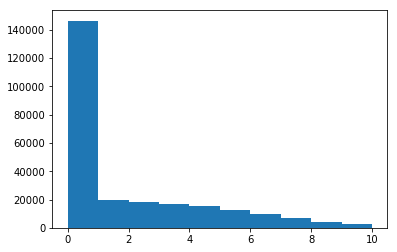

In [4]:
plt.hist(df.hit_E);

In [5]:
df.hit_x = (df.hit_x - df.hit_x.mean()) / df.hit_x.std()
df.hit_y = (df.hit_y - df.hit_y.mean()) / df.hit_y.std()
#df.hit_E = (df.hit_E - df.hit_E.mean()) / df.hit_E.std()

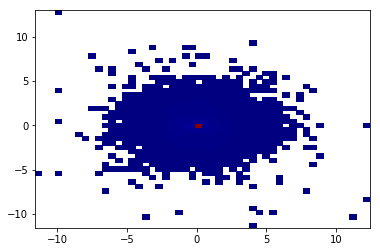

In [50]:
plt.hist2d(df.hit_x, df.hit_y,  bins=50,cmap=my_cmap, cmin=1e-10);


In [47]:
# plt.figure(figsize=(21,16))
# for i in range(1,15):
#     plt.subplot(4,4, i)
#     cuts = df[np.logical_and(df.magn_len == i, df.magn_x == 4)]
#     plt.hist2d(cuts.hit_x, cuts.hit_y, bins=50,cmap=my_cmap, cmin=1e-10)
#     plt.colorbar()
#     plt.grid()
#     plt.title(f"{i}")

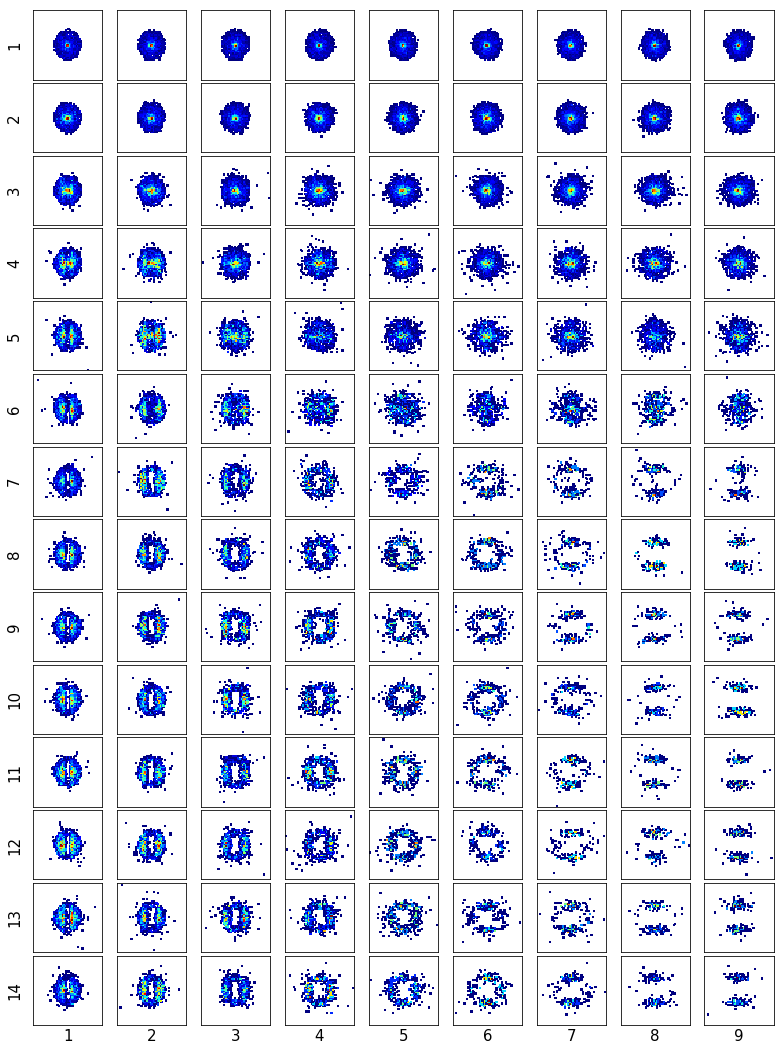

In [6]:
import matplotlib.gridspec as gridspec
plt.figure(figsize=(15,20))
gs1 = gridspec.GridSpec(15, 10)
gs1.update(wspace=0.025, hspace=0.05)

for i in range(1,15):
    for j in range(1,10):
        ax = plt.subplot(gs1[i,j])
        mask = np.logical_and(df.magn_len == i, df.magn_x == j)
        mask = np.logical_and(df.hit_E > 0, mask)
        plt.hist2d(df[mask].hit_x, df[mask].hit_y,
                   bins=50, cmap=my_cmap, cmin=1e-10, range=((-7, 7), (-7, 7)))
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_aspect('equal')
        if j == 1:
            ax.set_ylabel(i, fontsize=15)
        if i == 14:
            ax.set_xlabel(j, fontsize=15)
        plt.tick_params(
            axis='both',       
            which='both',      
            bottom=False,      
            left=False,
            labelbottom=False)        
plt.savefig("2d_plots/true_all_dist.pdf")        

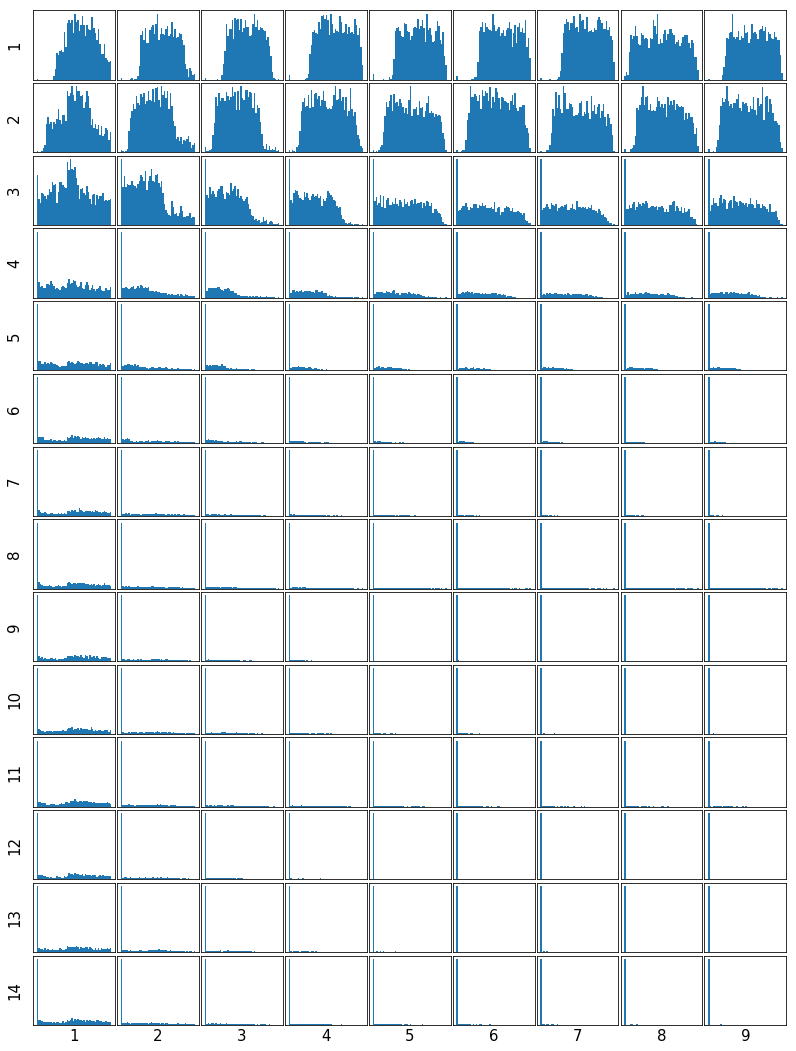

In [7]:
import matplotlib.gridspec as gridspec
plt.figure(figsize=(15,20))
gs1 = gridspec.GridSpec(15, 10)
gs1.update(wspace=0.025, hspace=0.05)

for i in range(1,15):
    for j in range(1,10):
        ax = plt.subplot(gs1[i,j])
        mask = np.logical_and(df.magn_len == i, df.magn_x == j)
        plt.hist(df[mask].hit_E, bins=50)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        #ax.set_aspect('equal')
        if j == 1:
            ax.set_ylabel(i, fontsize=15)
        if i == 14:
            ax.set_xlabel(j, fontsize=15)
        plt.tick_params(
            axis='both',       
            which='both',      
            bottom=False,      
            left=False,
            labelbottom=False)        

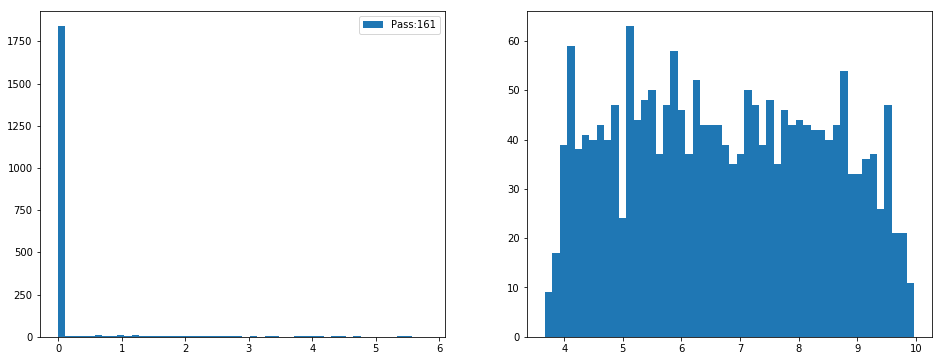

In [29]:
plt.figure(figsize=(16,6))
mask = np.logical_and(df.magn_len == 14, df.magn_x == 9)
plt.subplot(1,2,1)
plt.hist(df[mask].hit_E, bins=50, label="Pass:{}".format((df[mask].hit_E > 0).sum()));

plt.legend()

plt.subplot(1,2,2)
plt.hist(df[mask].start_pz, bins=50);

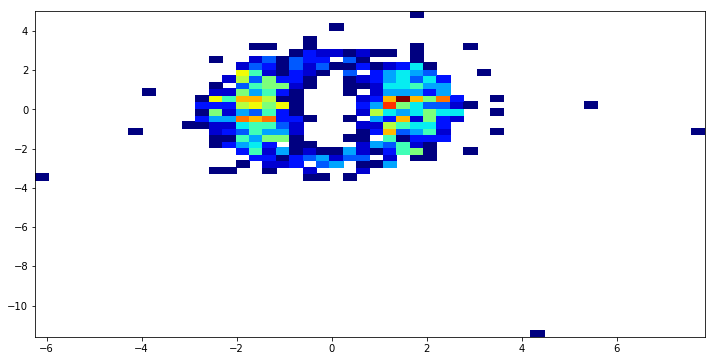

In [25]:
m_len = 14
m_x = 2
mask = np.logical_and(df.magn_len == m_len, df.magn_x == m_x)
mask = np.logical_and(df.hit_E > 0, mask)
plt.figure(figsize=(12,6))
plt.hist2d(df[mask].hit_x, df[mask].hit_y, bins=50, cmap=my_cmap, cmin=1e-10);

### load GAN

In [7]:
from comet_ml import API
import comet_ml

comet_api = API()
comet_api.get()

exp = comet_api.get("shir994/physics-2d/76bdfb7db00441e0a1a52b91a3393fed")
hyper_params = {}
for param in exp.parameters:
    hyper_params[param["name"]] = param["valueMin"]

In [8]:
hyper_params['NOISE_DIM'] = int(hyper_params['NOISE_DIM'])
hyper_params['param_dim'] = int(hyper_params['param_dim'])
hyper_params['x_dim'] = int(hyper_params['x_dim'])

In [9]:
from gan import Generator
generator = Generator(hyper_params['NOISE_DIM'], 3, hidden_dim=100,
          input_param=hyper_params['param_dim'] + hyper_params['x_dim']).to(device)

import io

asset_id = [exp_a['assetId'] for exp_a in exp.asset_list if exp_a['fileName'] == "physics_gan.tar"][0]
params = exp.get_asset(asset_id)
state_dict = torch.load(io.BytesIO(params))
generator.load_state_dict(state_dict['gen_state_dict'])

In [10]:
def sample_noise(N, NOISE_DIM):
    return np.random.normal(size=(N,NOISE_DIM)).astype(np.float32)

def genearte_plot_data(n_samples, magn_len, magn_x):
        theta = torch.empty(size=[n_samples,1]).uniform_(df.start_theta.min(), df.start_theta.max())
        phi = torch.empty(size=[n_samples,1]).uniform_(df.start_phi.min(), df.start_phi.max())
        p = torch.empty(size=[n_samples,1]).uniform_(df.start_P.min(), df.start_P.max())

        pids = torch.distributions.Bernoulli(probs=0.5).sample([n_samples, 1])
        pids[pids == 1] = 13.
        pids[pids == 0] = -13.

        noise = torch.Tensor(sample_noise(n_samples, hyper_params['NOISE_DIM'])).to(device)
        distr = generator(noise, torch.cat([pids, theta, phi, p, magn_len, magn_x], dim=1).to(device)).detach().cpu().numpy()     
        return distr
    
def generate_data(n_samples, magn_len, magn_x):
    magn_len = torch.Tensor([magn_len]).repeat([n_samples, 1])
    magn_x = torch.Tensor([magn_x]).repeat([n_samples, 1])
    return genearte_plot_data(n_samples, magn_len, magn_x)
    
def draw_hitmap(n_samples=100):
    f = plt.figure(figsize=(21,16))
    for index in range(16):
        plt.subplot(4,4, index + 1)
        
        
        magn_len = torch.empty(size=[1, 1], dtype=torch.float32).uniform_(1, 15).repeat([n_samples, 1])
        magn_x = torch.empty(size=[1, 1], dtype=torch.float32).uniform_(1, 10).repeat([n_samples, 1])
        distr = genearte_plot_data(n_samples, magn_len, magn_x)
        #distr = distr[distr[:, 2] > 5 * 1e-1]
        #distr = distr[np.logical_and(np.abs(distr[:, 0]) >= 0.1, np.abs(distr[:, 1]) >= 0.1)]
        #print((np.abs(distr[:,0]) < 0.05).sum())
        plt.hist2d(distr[:,0], distr[:, 1], bins=50, cmap=my_cmap, cmin=1e-10)
        plt.grid()
        plt.colorbar()
        plt.title("len={:.2f}, x={:.2f}".format(magn_len[0,0].item(), magn_x[0,0].item()), fontsize=15)
    return f

def draw_energy(n_samples=100):
    f = plt.figure(figsize=(21,16))
    for index in range(16):
        plt.subplot(4,4, index + 1)
        
        
        magn_len = torch.empty(size=[1, 1], dtype=torch.float32).uniform_(1, 15).repeat([n_samples, 1])
        magn_x = torch.empty(size=[1, 1], dtype=torch.float32).uniform_(1, 10).repeat([n_samples, 1])
        distr = genearte_plot_data(n_samples, magn_len, magn_x)
        #distr = distr[distr[:, 2] > 1e-5]

        #plt.hist2d(distr[:,0], distr[:, 1], bins=50, cmap=my_cmap, cmin=1e-10)
        plt.hist(distr[:, 2], bins=50, range=(-1,0.25))
        plt.grid()
        plt.title("len={:.2f}, x={:.2f}".format(magn_len[0,0].item(), magn_x[0,0].item()), fontsize=15)
    return f

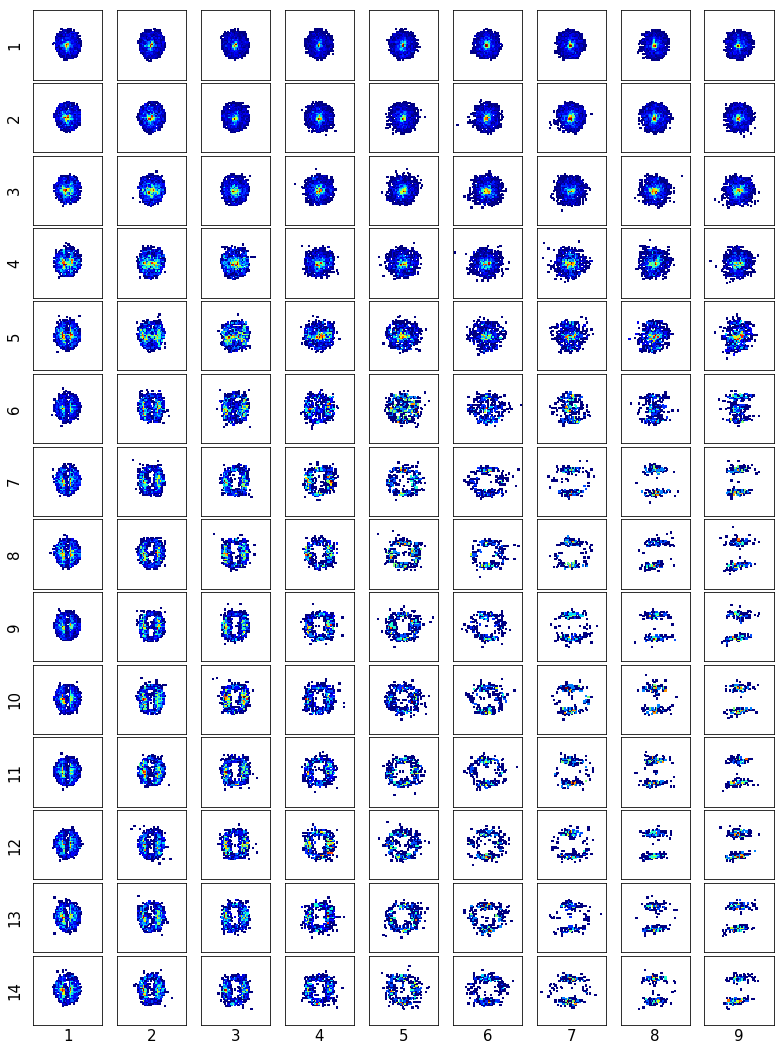

In [14]:
n_samples=2000
import matplotlib.gridspec as gridspec
plt.figure(figsize=(15,20))
gs1 = gridspec.GridSpec(15, 10)
gs1.update(wspace=0.025, hspace=0.05)

for i in range(1,15):
    for j in range(1,10):
        ax = plt.subplot(gs1[i,j])
        gen_data = generate_data(n_samples, i, j)
        gen_data = gen_data[gen_data[:, 2] > THRESHOLD]
        plt.hist2d(gen_data[:,0], gen_data[:,1],
                   bins=50, cmap=my_cmap, cmin=1e-10, range=((-7, 7), (-7, 7)))
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_aspect('equal')
        if j == 1:
            ax.set_ylabel(i, fontsize=15)
        if i == 14:
            ax.set_xlabel(j, fontsize=15)
        plt.tick_params(
            axis='both',       
            which='both',      
            bottom=False,      
            left=False,
            labelbottom=False)        
plt.savefig("2d_plots/gan_all_dist.pdf")        

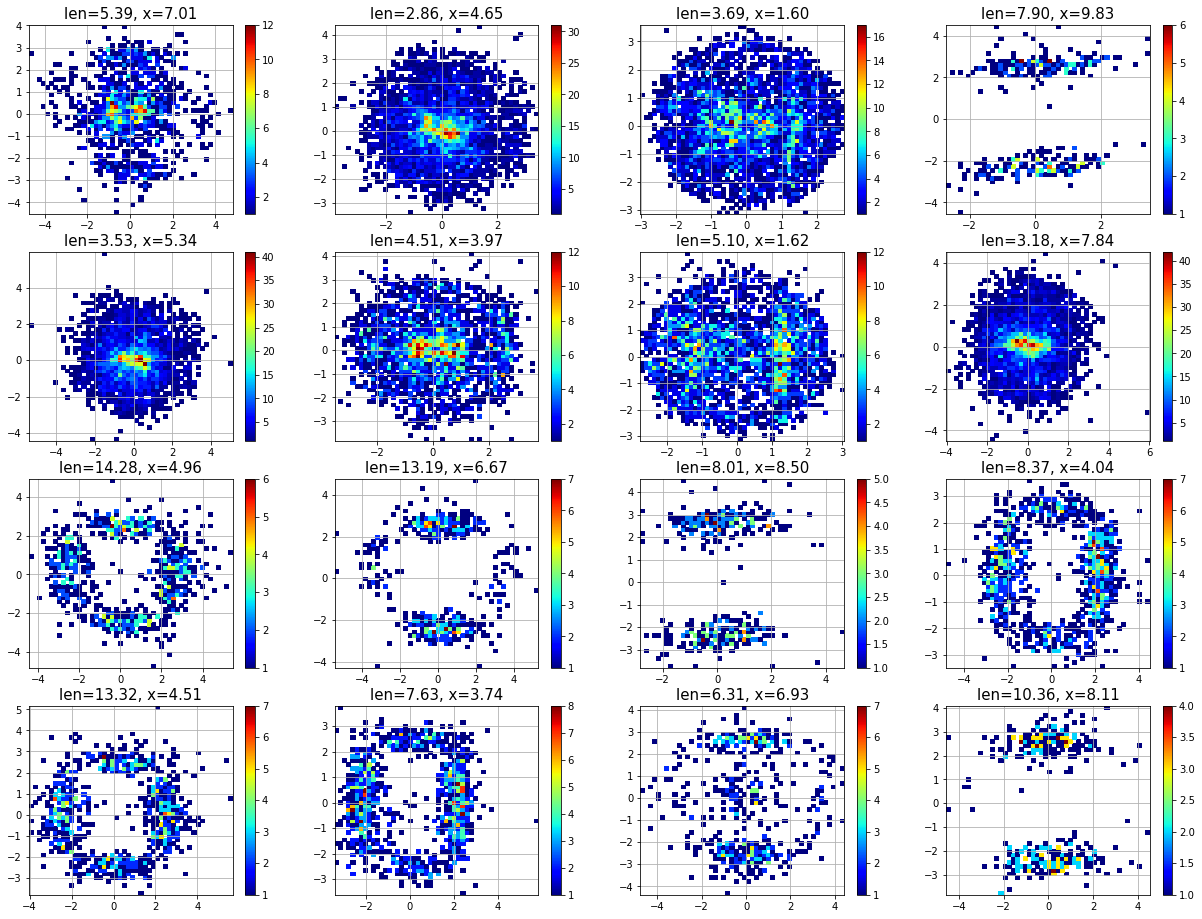

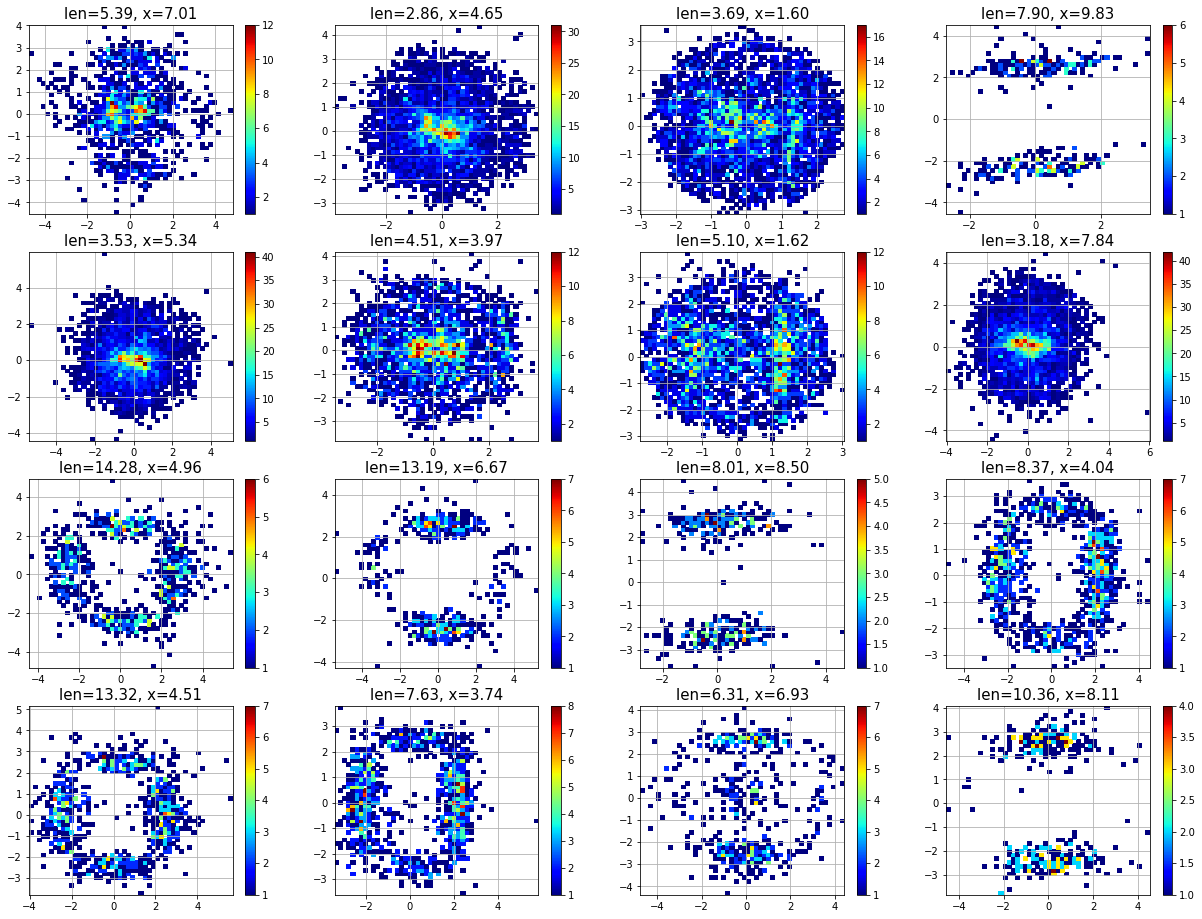

In [73]:
#plt.figure(figsize=(2,))
draw_hitmap(n_samples=5000)

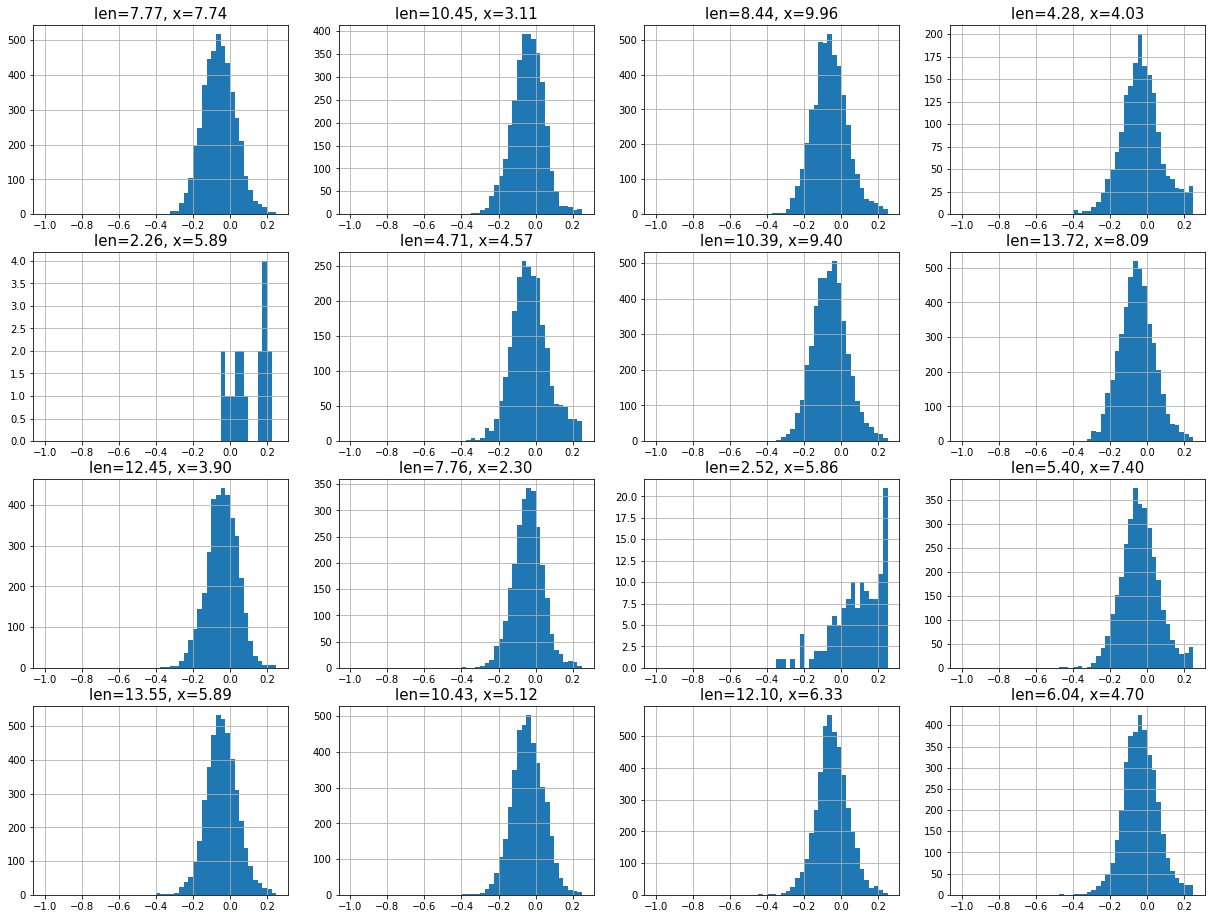

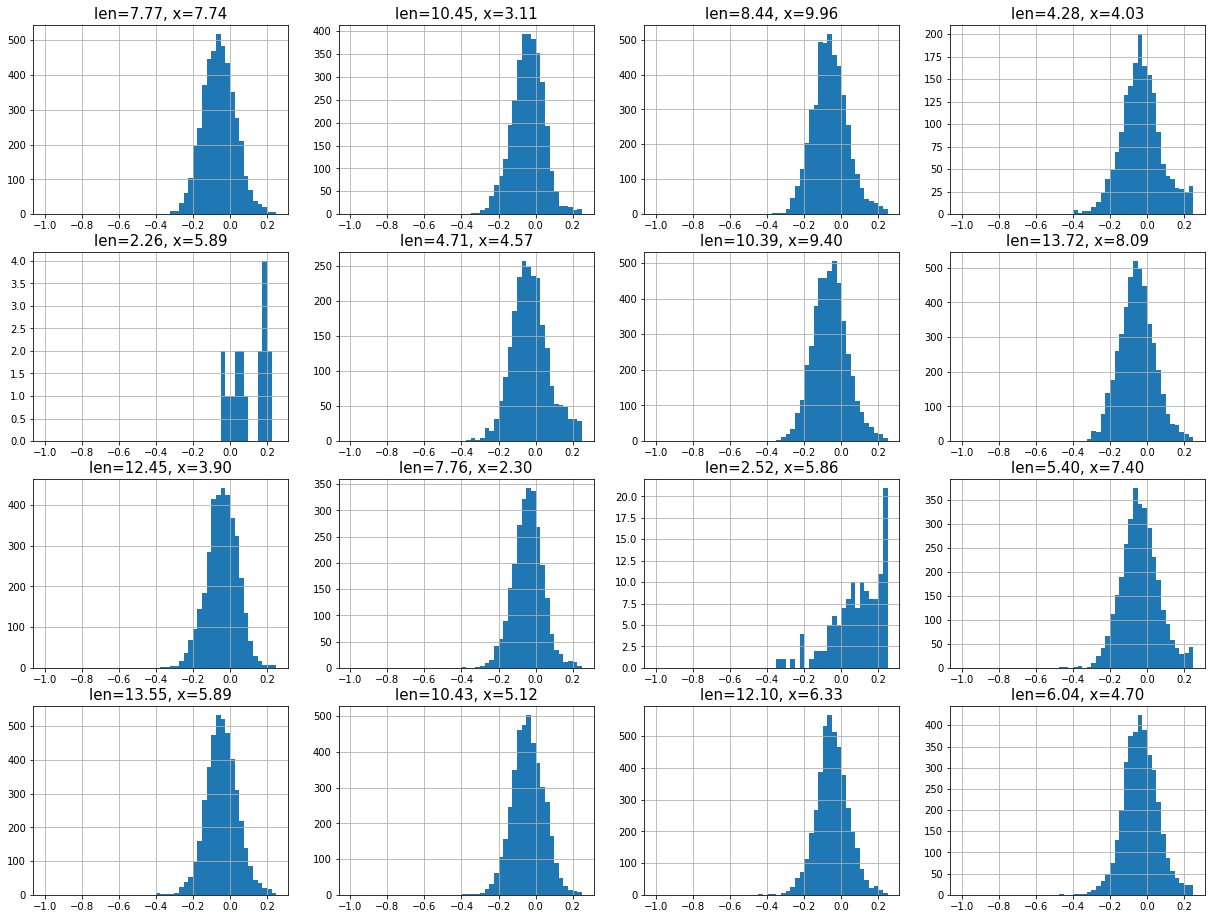

In [39]:
draw_energy(n_samples=5000)